In [1]:
#fetch the MNIST dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
#set features and prediction target
X,y = mnist["data"], mnist["target"]

#explore features
print('Features shape', X.shape)

#explore prediction target
print('Target shape', y.shape)

Features shape (70000, 784)
Target shape (70000,)


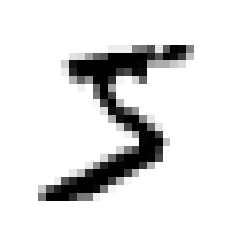

5

In [3]:
#exploring features vector and viewing image
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

#view image
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()
y = y.astype(np.uint8)
y[0]

In [4]:
#split the data into training and test sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [5]:
#train binary classifier to start the project, shall detect 5's
y_train_5 = (y_train ==5) #True for all 5s, false for other digits
y_test_5 = (y_test == 5)

In [6]:
#pick SGD as model
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [7]:
#correctly identifies the 5 example
sgd_clf.predict([some_digit])

array([ True])

In [8]:
#implement cross validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/ len(y_pred))

C:\Users\jacob\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.95035
0.96035
0.9604


In [9]:
#score the cross validation implemented above
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.95035, 0.96035, 0.9604 ])

In [10]:
#in an attempt to get a better performance measurement, we'll build a confusion matrix

#need to compute a set of predictions to compare to targets
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [11]:
#calculate confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [12]:
from sklearn.metrics import precision_score, recall_score

#calculate the precision of the classifier, aka the accuracy of positive predictions
#precision = true positives/ (true positives + false positives)

p_score = precision_score(y_train_5, y_train_pred) *100

#furthermore, precision should be used with other metrics susch as recall
#aka sensitivity, aka true positive rate
#recall = True Positives/ (True positives + false negatives)

r_score = recall_score(y_train_5, y_train_pred) *100


#print
print("Precision score {:10.10f}(%)\n\nRecall Score {:10.10f}(%)".format(p_score, r_score))

Precision score 83.7087977235(%)

Recall Score 65.1171370596(%)


In [13]:
#combine the precision score and the recall score to obtain the F1 score
#which achieves the harmonic mean of precision and recall
#F1 = 2/((1/precision) + (1/recall)) = 
#     2X ((precision X recall)/(precision + recall))
#     TP/(TP + ((FN+FP)/2))

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)


0.7325171197343846

In [18]:
#in order to better understand the tradeoff between precision and recall
# you can call decision_function to return a score for each instance and then 
# you can make decisions based on those scores, using any threshold you want

y_scores = sgd_clf.decision_function([some_digit])
print("Decision function score of 5 example ", y_scores)

threshold = 0 
y_some_digit_pred = (y_scores > threshold)
print("\nIs the instance score of the example greater than the decision threshold?{}".format(y_some_digit_pred))



Decision function score of 5 example  [2164.22030239]

Is the instance score of the example greater than the decision threshold?[ True]


In [19]:
#raise the decision threshold just to see the decision function at work
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print("\nIs the instance score of the example greater than the decision threshold?{}".format(y_some_digit_pred))



Is the instance score of the example greater than the decision threshold?[False]


In [22]:
# to make the crucial decision of which threshold to use (and make the decision between precision and recall)
# then you return the scores of the training set using cross_val_predicts and returning the decision function

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")



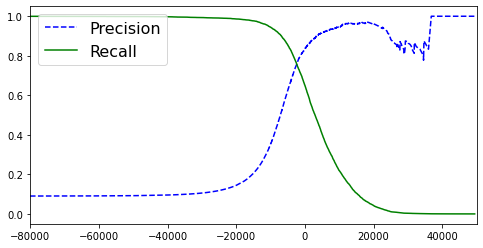

In [35]:
#then use the precision_recall_curve() function to
#compute precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

#plot precision recall curves
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):    
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")    
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")    
    plt.legend(loc="upper left", fontsize=16)
    
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-80000, 50000])
plt.show()

In [38]:
#if you want to set the precision to a certain number, say 90%
# you search for the lowest threshold that gives 90% precision

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

print("90% precision threshold {}".format(threshold_90_precision))

90% precision threshold 3370.0194991439594


In [48]:
# then to make predictoins you can run
y_train_pred_90 = (y_scores >= threshold_90_precision)


#now check the predictiosn precision and recall
p_score = precision_score(y_train_5, y_train_pred_90)

print("90% precision threshold \n\tprecision score\t {:12.12f}(%)".format(p_score*100))

#now check the predictions recall
r_score = recall_score(y_train_5, y_train_pred_90)

print("90% precision threshold \n\trecall score\t {:12.12f}(%)".format(r_score *100))

90% precision threshold 
	precision score	 90.003459010723(%)
90% precision threshold 
	recall score	 47.998524257517(%)


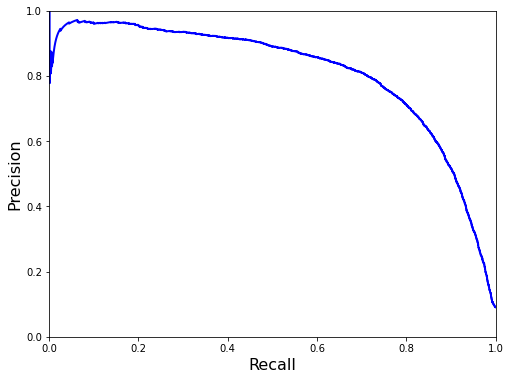

In [49]:
def plot_precision_vs_recall(precision,recalls):
    plt.plot(recalls,precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0,1,0,1])
    
plt.figure(figsize=(8,6))
plot_precision_vs_recall(precisions,recalls)
plt.show()

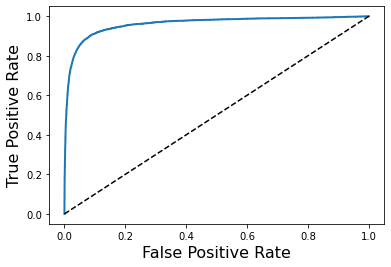

In [53]:
from sklearn.metrics import roc_curve

#plot the receiver operating characteristic (ROC) curve
#plot the true positive rate against the false positive rate

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')# dashed diagonal 
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plot_roc_curve(fpr, tpr)
plt.show()

In [54]:
#now we should measure the area under the curve
# a perfect score is 1, whereas a random classifier will have 
# a score of .5

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [57]:
#evaluating how scikit learn uses binary classifiers for multi class
# classification, as it runs one verse all 

sgd_clf.fit(X_train, y_train)
print(sgd_clf.predict([some_digit]))

some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

[3]


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [58]:
#forcing scikit learn to use One versus One classifier
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [ ]:
# time to start improving a model by analyzing errors

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx